# Fuel Efficiency Prediction
#### CHAPTER 05: _Global Model-agnostic Interpretation Methods_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [ ]:
!pip install --upgrade pandas numpy scikit-learn tensorflow xgboost scipy matplotlib seaborn

Install these if running on Google Colab or ***not already installed***:

!pip install --upgrade machine-learning-datasets
!pip install git+https://github.com/tensorflow/docs
!pip install --upgrade rulefit shap
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [7]:
import pandas as pd
import numpy as np

def make_dummies_with_limits(df, colname, min_recs=0.005,\
                             max_dummies=20, defcatname='Other',\
                             nospacechr='_'):
    if min_recs < 1:
        min_recs = df.shape[0]*min_recs
    topvals_df = df.groupby(colname).size().reset_index(name="counts").\
                    sort_values(by="counts", ascending=False).reset_index()
    other_l = topvals_df[(topvals_df.index > max_dummies) |\
                         (topvals_df.counts < min_recs)][colname].to_list()
    if len(other_l):
        df.loc[df[colname].isin(other_l), colname] = defcatname
    if len(nospacechr):
        df[colname] = df[colname].str.replace(' ',\
                                                  nospacechr, regex=False)
    return pd.get_dummies(df, prefix=[colname], columns=[colname])

def make_dummies_from_dict(df, colname, match_dict, 
                           drop_orig=True, nospacechr='_'):
    if type(match_dict) is list:
        if len(nospacechr):
            match_dict = {match_key:match_key.\
                              replace(' ', nospacechr)\
                              for match_key in match_dict }
        else:
            match_dict = {match_key:match_key\
                              for match_key in match_dict}
    for match_key in match_dict.keys():
        df[colname+'_'+match_dict[match_key]] =\
                    np.where(df[colname].str.contains(match_key), 1, 0)
    if drop_orig:
        return df.drop([colname], axis=1)
    else:
        return df

In [23]:
usecols = ["make", "model", "year", "fuelType", "cylinders", "displ", "eng_dscr", "phevBlended", "atvType", "co2TailpipeGpm", "co2", "ghgScore", "drive", "trany", "trans_dscr", "VClass", "pv4", "lv4", "lv2", "pv2", "hlv", "hpv", "startStop", "tCharger", "comb08"]
dtype = {"make":"object", "model":"object", "year":"int16", "fuelType":"object", "cylinders":"float32", "displ":"float32", "trany":"object", "drive":"object", "eng_dscr":"object", "trans_dscr":"object", "phevBlended":"bool", "co2":"int16", "ghgScore":"int16", "co2TailpipeGpm":"float32", "VClass":"object", "pv4":"int16", "lv4":"int16", "lv2":"int16", "pv2":"int16", "hlv":"int16", "hpv":"int16", "fuelCost08":"int16", "startStop":"object", "tCharger":"object", "atvType":"object", "comb08":"int16"}
df = pd.read_csv(r"C:\Users\lgarzia\Documents\GitHub\explainability\Interpretable-Machine-Learning-with-Python-master\Chapter05\data\vehicles.csv\vehicles.csv", 
                 usecols=usecols, dtype=dtype)
df.cylinders.fillna(0, inplace=True)
df.displ.fillna(0, inplace=True)
df.atvType.fillna('Unknown', inplace=True)
df.drive.fillna('Unknown', inplace=True)
df.trans_dscr.fillna('Unknown', inplace=True)
df.startStop.fillna('Unknown', inplace=True)
df.tCharger.fillna(0, inplace=True)
df.tCharger.replace('T', 1, inplace=True)
df = make_dummies_with_limits(df, 'fuelType')
df['drive'] = df['drive'].str.replace(' Drive', '', regex=False)
df = make_dummies_with_limits(df, 'drive')
df['VClass'] = df['VClass'].str.replace(' -', '', regex=False)
df = make_dummies_with_limits(df, 'VClass')
df = make_dummies_with_limits(df, 'startStop')
df = make_dummies_with_limits(df, 'atvType')
df['trans_spd'] = df.trany.str.extract('(\\d+)').fillna(0).astype(np.int8)
df = make_dummies_from_dict(df, 'trany', ['Automatic', 'Manual'])
df = make_dummies_from_dict(df, 'eng_dscr', ['FFS','SIDI','CA model','MPFI','FFV','TRBO','350 V8','PFI','GUZZLER','SOHC','NO-CAT'])
df = make_dummies_from_dict(df, 'trans_dscr',['Unknown','CLKUP','SIL','2MODE','Creeper','EMS','3MODE','2LKUP'])

### Loading the Libraries

In [24]:
import math
import os
#import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, tree
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import xgboost as xgb
from rulefit import RuleFit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from alepython import ale_plot

In [25]:
print(tf.__version__)

2.11.0


### Understanding and Preparing the Data

In [26]:
#fueleconomy_df = mldatasets.load("vehicle-fueleconomy", prepare=True)

In [27]:
fueleconomy_df = df
fueleconomy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46017 entries, 0 to 46016
Data columns (total 85 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   co2                                        46017 non-null  int16  
 1   co2TailpipeGpm                             46017 non-null  float32
 2   comb08                                     46017 non-null  int16  
 3   cylinders                                  46017 non-null  float32
 4   displ                                      46017 non-null  float32
 5   ghgScore                                   46017 non-null  int16  
 6   hlv                                        46017 non-null  int16  
 7   hpv                                        46017 non-null  int16  
 8   lv2                                        46017 non-null  int16  
 9   lv4                                        46017 non-null  int16  
 10  make                  

In [28]:
pd.set_option('display.max_columns', None)

In [29]:
fueleconomy_df.head(n=5)
#fuelType1

co2  co2TailpipeGpm  comb08  cylinders  displ  ghgScore  hlv  hpv  lv2  \
0   -1      423.190491      21        4.0    2.0        -1    0    0    0   
1   -1      807.909119      11       12.0    4.9        -1    0    0    0   
2   -1      329.148163      27        4.0    2.2        -1   19   77    0   
3   -1      807.909119      11        8.0    5.2        -1    0    0    0   
4   -1      467.736847      19        4.0    2.2        -1    0    0    0   

   lv4        make                model  phevBlended  pv2  pv4  year  \
0    0  Alfa Romeo   Spider Veloce 2000        False    0    0  1985   
1    0     Ferrari           Testarossa        False    0    0  1985   
2    0       Dodge              Charger        False    0    0  1985   
3    0       Dodge  B150/B250 Wagon 2WD        False    0    0  1985   
4   14      Subaru     Legacy AWD Turbo        False    0   90  1993   

   tCharger  fuelType_Diesel  fuelType_Electricity  fuelType_Gasoline_or_E85  \
0         0                0                     0                         0   
1         0                0                     0                         0   
2         0                0                     0                         0   
3         0                0                     0                         0   
4         1                0                     0                         0   

   fuelType_Other  fuelType_Premium  fuelType_Regular  drive_2-Wheel  \
0               0                 0                 1              0   
1               0                 0                 1              0   
2               0                 0                 1              0   
3               0                 0                 1              0   
4               0                 1                 0              0   

   drive_4-Wheel  drive_4-Wheel_or_All-Wheel  drive_All-Wheel  \
0              0                           0                0   
1              0                           0                0   
2              0                           0                0   
3              0                           0                0   
4              0                           1                0   

   drive_Front-Wheel  drive_Part-time_4-Wheel  drive_Rear-Wheel  \
0                  0                        0                 1   
1                  0                        0                 1   
2                  1                        0                 0   
3                  0                        0                 1   
4                  0                        0                 0   

   drive_Unknown  VClass_Compact_Cars  VClass_Large_Cars  \
0              0                    0                  0   
1              0                    0                  0   
2              0                    0                  0   
3              0                    0                  0   
4              0                    1                  0   

   VClass_Midsize-Large_Station_Wagons  VClass_Midsize_Cars  \
0                                    0                    0   
1                                    0                    0   
2                                    0                    0   
3                                    0                    0   
4                                    0                    0   

   VClass_Midsize_Station_Wagons  VClass_Minicompact_Cars  VClass_Other  \
0                              0                        0             0   
1                              0                        0             0   
2                              0                        0             0   
3                              0                        0             0   
4                              0                        0             0   

   VClass_Small_Pickup_Trucks  VClass_Small_Sport_Utility_Vehicle_2WD  \
0                           0                                       0   
1                           0                                 

#### Data Preparation

In [30]:
rand = 9
y = fueleconomy_df['comb08']
X = fueleconomy_df.drop(['comb08','make','model'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                    test_size=0.15, random_state=rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                    test_size=0.2, random_state=rand)

#### Modeling and Performance Evaluation for Deep Neural Network

In [31]:
os.environ['PYTHONHASHSEED']=str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [32]:
fitted_nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=[len(X_train.keys())]),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])
fitted_nn_model.compile(loss='mean_squared_error',\
                optimizer=tf.keras.optimizers.Adam(lr = 0.0005),\
                metrics=['mse'])
fitted_nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 82)               165       
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                5312      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,702
Trainable params: 9,537
Non-trainable params: 165
_________________________________________________________________


In [33]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,\
                                      patience=200, min_delta=0.0005,\
                                      restore_best_weights=True)
nn_history = fitted_nn_model.fit(\
                X_train.astype(float), y_train.astype(float), epochs=3000, batch_size=128,\
                validation_data=(X_val.values.astype(float), y_val.values.astype(float)), verbose=1,\
                                 callbacks=[es])

Epoch 1/3000
245/245 [==============================] - 2s 3ms/step - loss: 26.0210 - mse: 26.0210 - val_loss: 8.6181 - val_mse: 8.6181
Epoch 2/3000
245/245 [==============================] - 1s 2ms/step - loss: 7.3067 - mse: 7.3067 - val_loss: 6.2557 - val_mse: 6.2557
Epoch 3/3000
245/245 [==============================] - 1s 2ms/step - loss: 6.6654 - mse: 6.6654 - val_loss: 6.0609 - val_mse: 6.0609
Epoch 4/3000
245/245 [==============================] - 1s 2ms/step - loss: 5.8705 - mse: 5.8705 - val_loss: 5.1318 - val_mse: 5.1318
Epoch 5/3000
245/245 [==============================] - 1s 2ms/step - loss: 6.2971 - mse: 6.2971 - val_loss: 9.3213 - val_mse: 9.3213
Epoch 6/3000
245/245 [==============================] - 1s 2ms/step - loss: 7.5148 - mse: 7.5148 - val_loss: 9.3498 - val_mse: 9.3498
Epoch 7/3000
245/245 [==============================] - 1s 2ms/step - loss: 6.9486 - mse: 6.9486 - val_loss: 5.5519 - val_mse: 5.5519
Epoch 8/3000
245/245 [==============================] - 1s 2

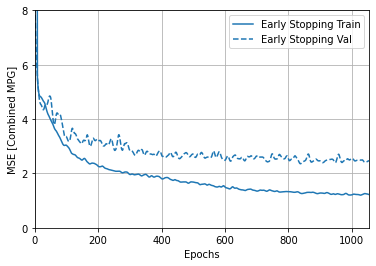

In [12]:
nn_plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
nn_plotter.plot({'Early Stopping': nn_history}, metric = "mse")
plt.rc("figure", figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.ylabel('MSE [Combined MPG]')
plt.ylim([0, 8])
plt.show()

In [34]:
y_train_nn_pred = fitted_nn_model(X_train.astype(float))
y_test_nn_pred = fitted_nn_model.predict(X_test.astype(float))
RMSE_nn_train = metrics.mean_squared_error(y_train,\
                                        y_train_nn_pred, squared=False)
RMSE_nn_test = metrics.mean_squared_error(y_test,\
                                        y_test_nn_pred, squared=False)
R2_nn_test = metrics.r2_score(y_test, y_test_nn_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_nn_train, RMSE_nn_test, R2_nn_test))

216/216 [==============================] - 0s 1ms/step
RMSE_train: 1.0957	RMSE_test: 1.2247	r2: 0.9852


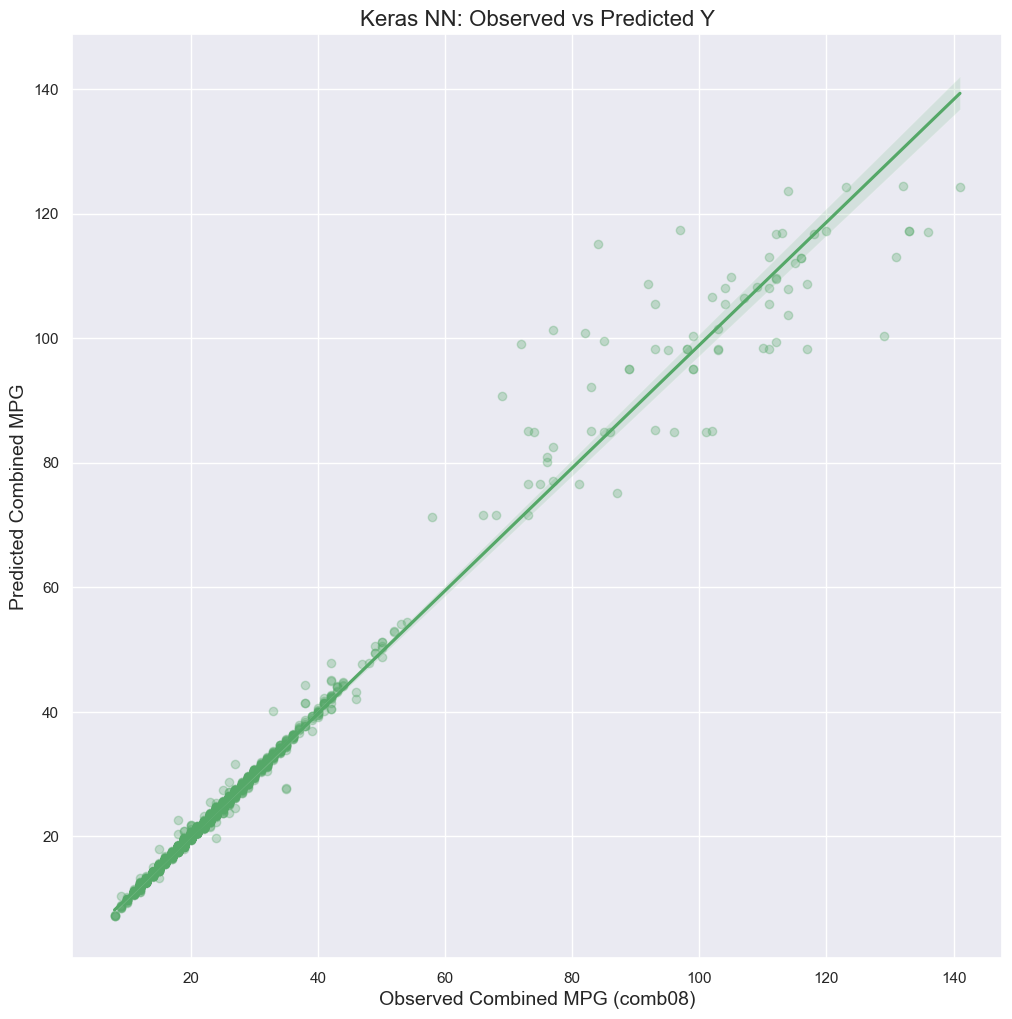

In [35]:
sns.set()
plt.figure(figsize = (12,12))
plt.title('Keras NN: Observed vs Predicted Y', fontsize=16)
plt.ylabel('Predicted Combined MPG', fontsize=14)
sns.regplot(x=y_test, y=y_test_nn_pred, color="g",\
            scatter_kws={'alpha':0.3})
plt.xlabel('Observed Combined MPG (comb08)', fontsize=14)
plt.show() 

#### Modeling and Performance Evaluation for XGBoost

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [37]:
fitted_xgb_model = xgb.XGBRegressor(max_depth=7, learning_rate=0.6,\
                    n_jobs=4, objective='reg:squarederror',\
                    random_state=rand, n_estimators=50).\
                    fit(X_train, y_train,\
                    eval_set=[(X_train, y_train),(X_val, y_val)],\
                    eval_metric='rmse')

[0]	validation_0-rmse:9.33999	validation_1-rmse:9.32838
[1]	validation_0-rmse:3.90388	validation_1-rmse:3.91430
[2]	validation_0-rmse:1.80766	validation_1-rmse:1.99358


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[3]	validation_0-rmse:1.07324	validation_1-rmse:1.35947
[4]	validation_0-rmse:0.87082	validation_1-rmse:1.25356
[5]	validation_0-rmse:0.75346	validation_1-rmse:1.15480
[6]	validation_0-rmse:0.72461	validation_1-rmse:1.13736
[7]	validation_0-rmse:0.70002	validation_1-rmse:1.11077
[8]	validation_0-rmse:0.67942	validation_1-rmse:1.09653
[9]	validation_0-rmse:0.66069	validation_1-rmse:1.09459
[10]	validation_0-rmse:0.63256	validation_1-rmse:1.08874
[11]	validation_0-rmse:0.61661	validation_1-rmse:1.08502
[12]	validation_0-rmse:0.61065	validation_1-rmse:1.08133
[13]	validation_0-rmse:0.59428	validation_1-rmse:1.08300
[14]	validation_0-rmse:0.59231	validation_1-rmse:1.08082
[15]	validation_0-rmse:0.58313	validation_1-rmse:1.09564
[16]	validation_0-rmse:0.57721	validation_1-rmse:1.09911
[17]	validation_0-rmse:0.57584	validation_1-rmse:1.09864
[18]	validation_0-rmse:0.57161	validation_1-rmse:1.09783
[19]	validation_0-rmse:0.57068	validation_1-rmse:1.09786
[20]	validation_0-rmse:0.56948	validat

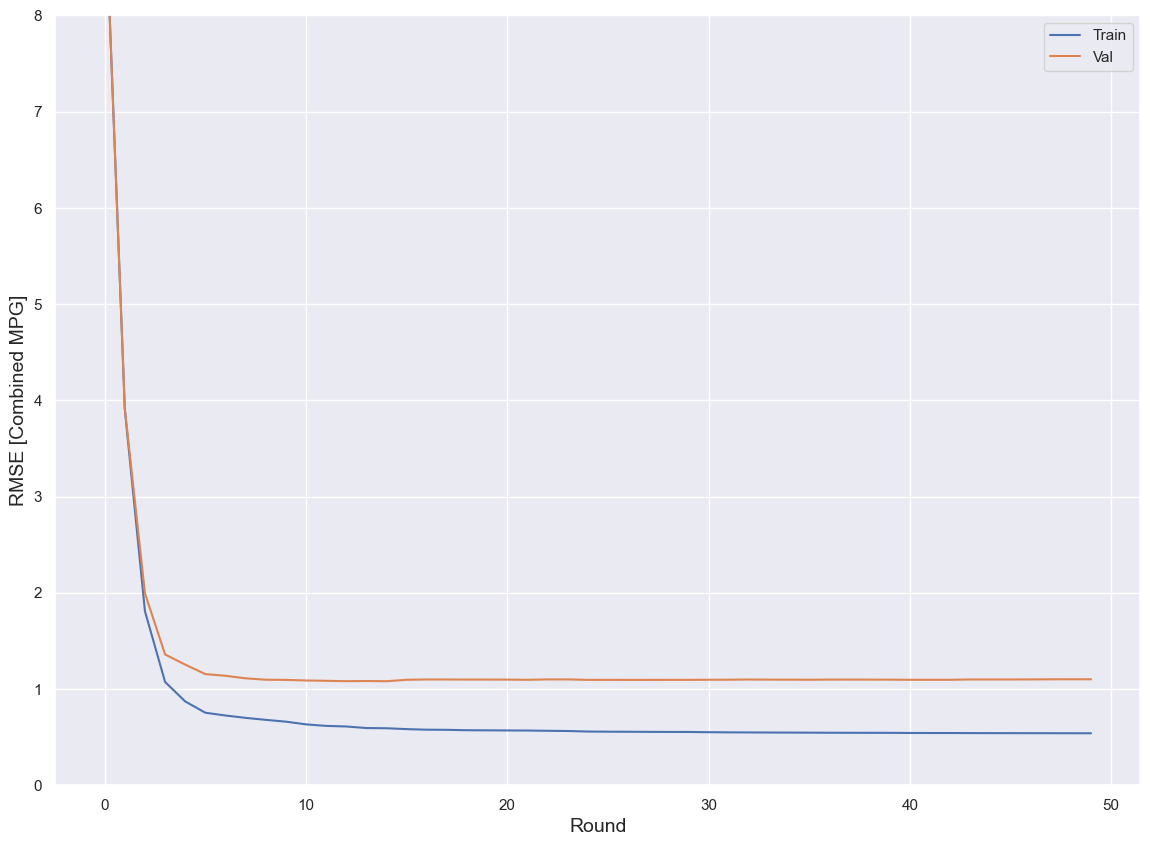

In [38]:
plt.figure(figsize=(14, 10))
plt.rcParams.update({'font.size': 14})
plt.plot(fitted_xgb_model.evals_result()['validation_0']['rmse'])
plt.plot(fitted_xgb_model.evals_result()['validation_1']['rmse'])
plt.ylabel('RMSE [Combined MPG]', fontsize=14)
plt.ylim([0, 8])
plt.xlabel('Round', fontsize=14)
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [39]:
y_train_xgb_pred = fitted_xgb_model.predict(X_train)
y_test_xgb_pred = fitted_xgb_model.predict(X_test)
RMSE_xgb_train = math.sqrt(\
                    metrics.mean_squared_error(y_train,\
                                               y_train_xgb_pred))
RMSE_xgb_test = math.sqrt(\
                    metrics.mean_squared_error(y_test,
                                               y_test_xgb_pred))
R2_xgb_test = metrics.r2_score(y_test, y_test_xgb_pred)
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                    (RMSE_xgb_train, RMSE_xgb_test, R2_xgb_test))

RMSE_train: 0.5401	RMSE_test: 0.9215	r2: 0.9916


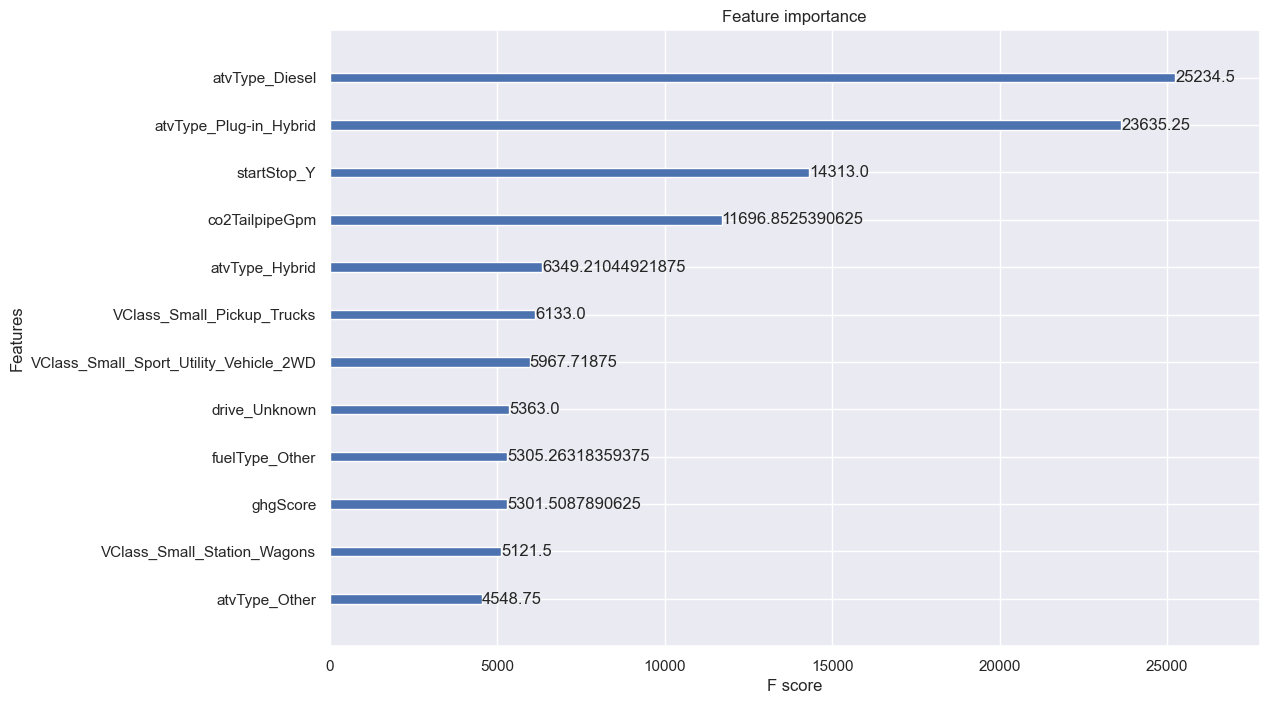

In [42]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(fitted_xgb_model, max_num_features=12, ax=ax,\
                    importance_type="cover")
plt.show()

## Interpreting SHAP Summary and Dependence Plots

### Initializing Explainers

In [43]:
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model)

In [54]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 150, replace=False)]
print(background.shape)
print(X_train.shape)
print(background.astype(float).values.shape)
shap_nn_explainer = shap.GradientExplainer(fitted_nn_model, background)
#shap_nn_explainer = shap.GradientExplainer(fitted_nn_model, shap.kmeans(X_train, 82))

(150, 82)
(31291, 82)
(150, 82)


### Computing SHAP Values

In [55]:
shap_xgb_values_train = shap_xgb_explainer.shap_values(X_train)
print(shap_xgb_values_train.shape)
shap_xgb_values_test = shap_xgb_explainer.shap_values(X_test)
print(shap_xgb_values_test.shape)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(31291, 82)
(6903, 82)


In [63]:
shap_nn_values_test = shap_nn_explainer.shap_values(X_test)
print(type(shap_nn_values_test))
print(shap_nn_values_test[0].shape)

AttributeError: 'DataFrame' object has no attribute 'reshape'

### Generating SHAP Summary Plots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


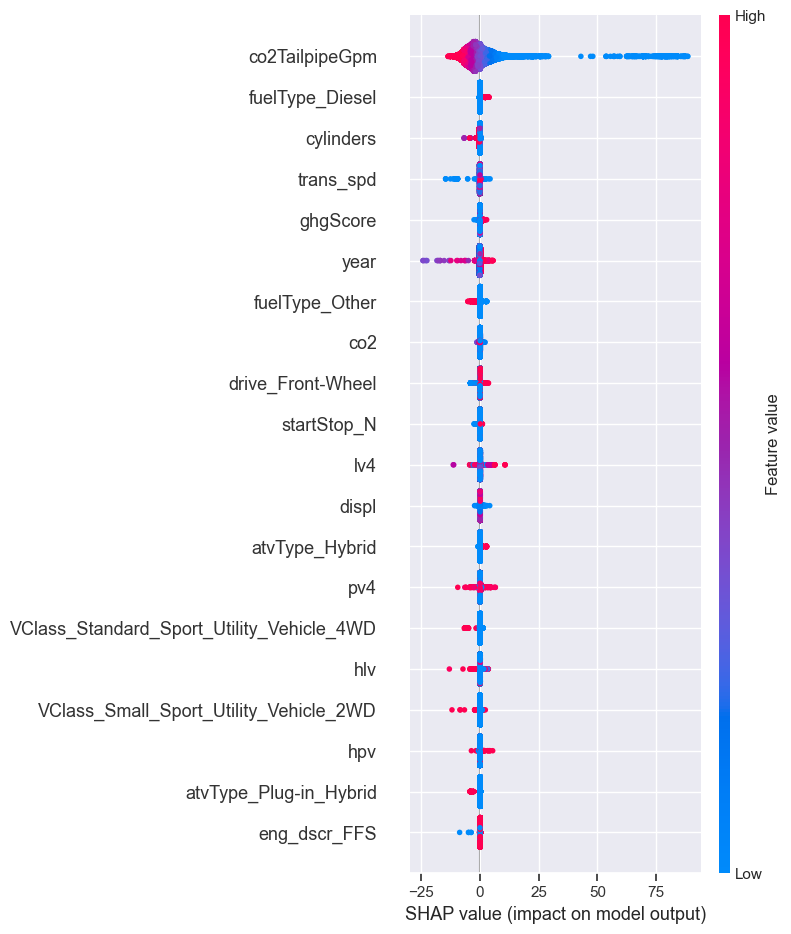

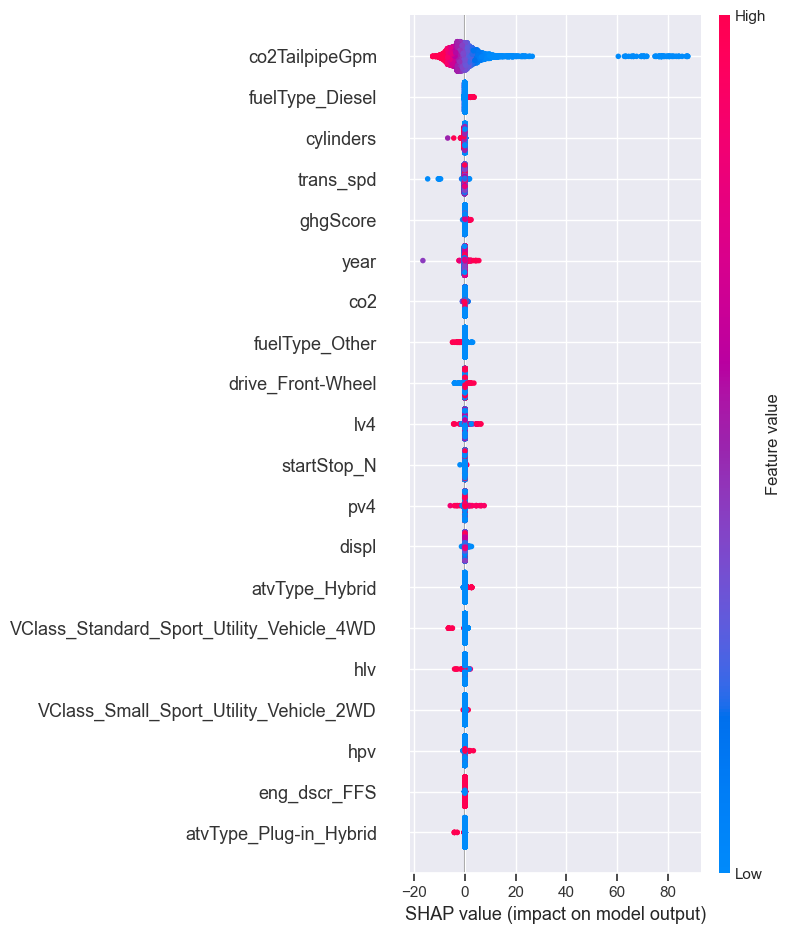

In [60]:
shap.summary_plot(shap_xgb_values_train, X_train, plot_type="dot")
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="dot")

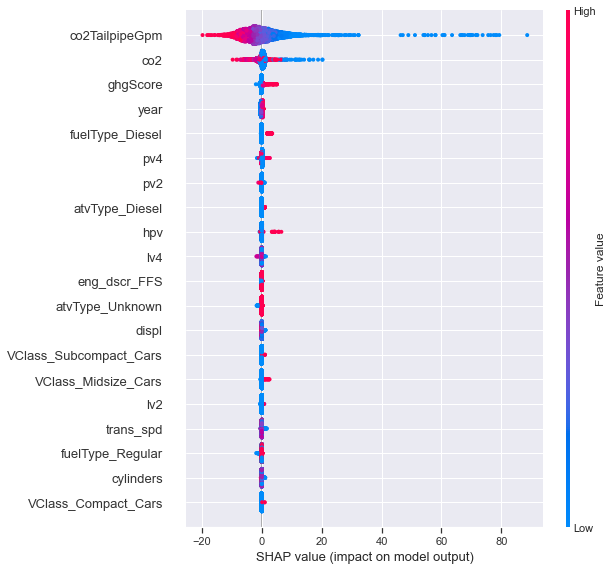

In [45]:
shap.summary_plot(shap_nn_values_test[0], X_test, plot_type="dot")

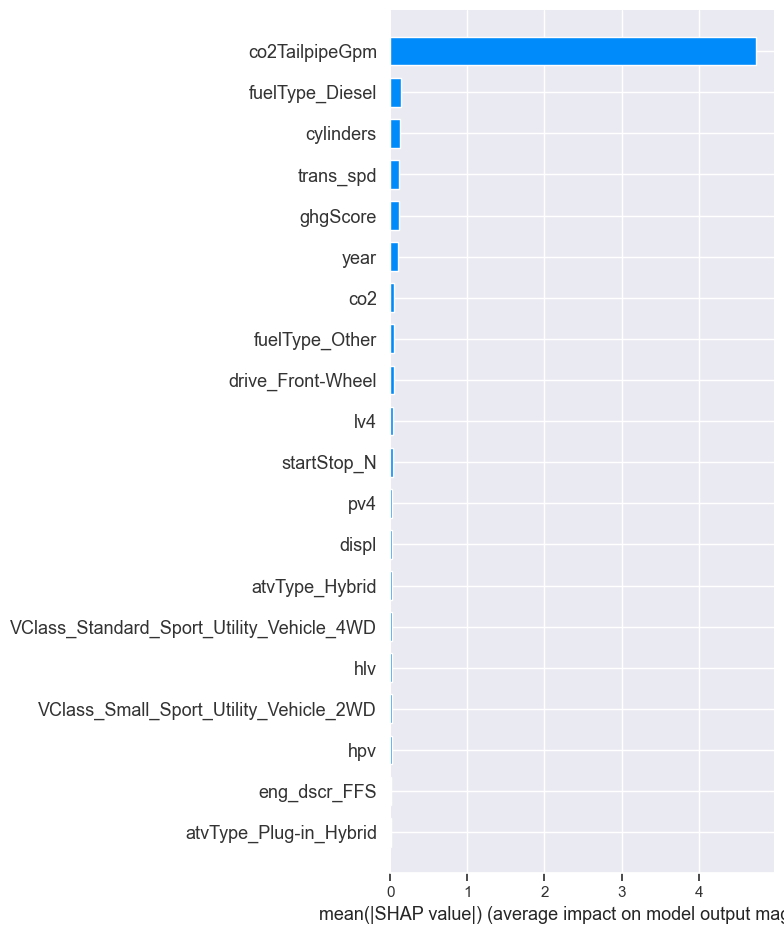

In [64]:
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="bar")
#shap.summary_plot(shap_nn_values_test[0], X_test, plot_type="bar")

### Understanding Interactions

In [65]:
top_features_l = ['comb08'] + ['co2TailpipeGpm', 'fuelType_Diesel',\
                               'co2', 'year', 'ghgScore', 'cylinders']
top_df = fueleconomy_df.loc[X_train.index, top_features_l]

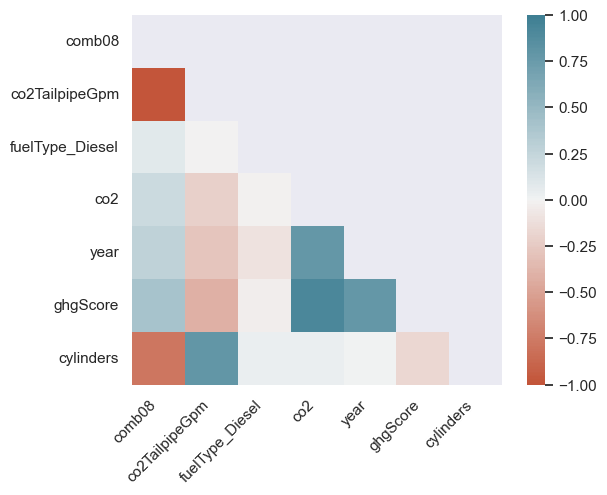

In [66]:
corrs = stats.spearmanr(top_df).correlation
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(
    corrs, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    xticklabels=top_df.columns,
    yticklabels=top_df.columns,
    mask=mask,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [67]:
print('spearman\tco2TailpipeGpm→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2TailpipeGpm.values, top_df.comb08.values)))
print('point-biserial\tfuelType_Diesel→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.pointbiserialr(top_df.fuelType_Diesel.values, top_df.comb08.values)))
print('spearman\tco2→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2.values, top_df.comb08.values)))
print('spearman\tyear→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.year.values, top_df.comb08.values)))
print('spearman\tghgScore→comb08\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.comb08.values)))
print('spearman\tcylinders→comb08\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, top_df.comb08.values)))

spearman	co2TailpipeGpm→comb08	corr: -0.992	p-val: 0.0000
point-biserial	fuelType_Diesel→comb08	corr: 0.046	p-val: 0.0000
spearman	co2→comb08		corr: 0.207	p-val: 0.0000
spearman	year→comb08		corr: 0.270	p-val: 0.0000
spearman	ghgScore→comb08		corr: 0.405	p-val: 0.0000
spearman	cylinders→comb08	corr: -0.787	p-val: 0.0000


### SHAP Dependence Plots

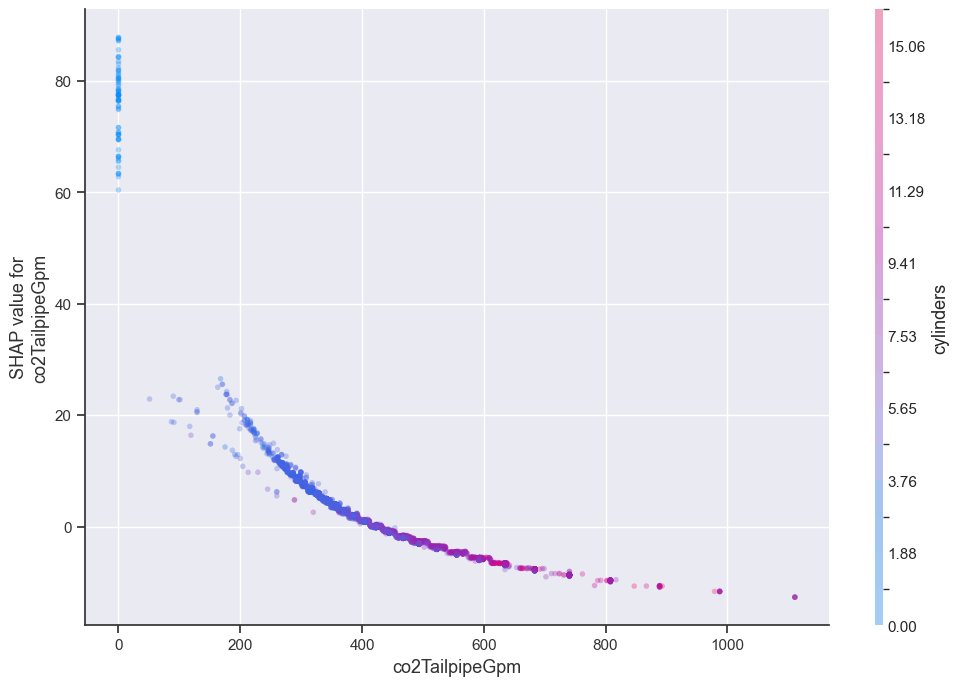

spearman	cylinders→co2TailpipeGpm	corr: 0.791	p-val: 0.0000


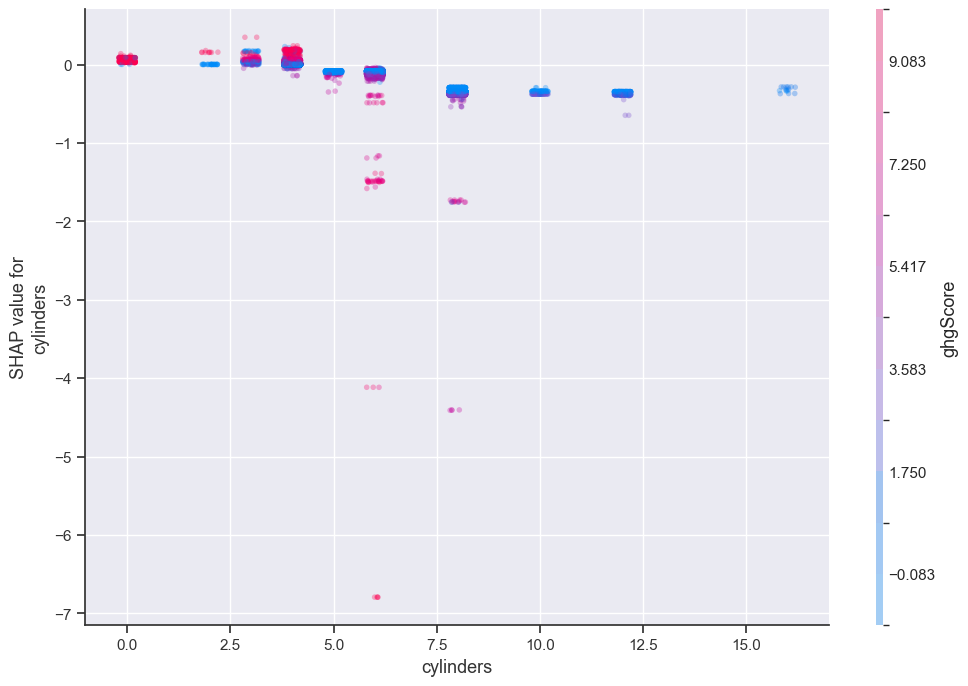

spearman	ghgScore→cylinders		corr: -0.156	p-val: 0.0000


In [68]:
shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_test, X_test,\
                     interaction_index="cylinders", show=False, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tcylinders→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.cylinders.values, X_train.co2TailpipeGpm.values)))
shap.dependence_plot("cylinders", shap_xgb_values_train, X_train,\
                     interaction_index="ghgScore", show=False,\
                     x_jitter=0.4, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→cylinders\t\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.cylinders.values)))

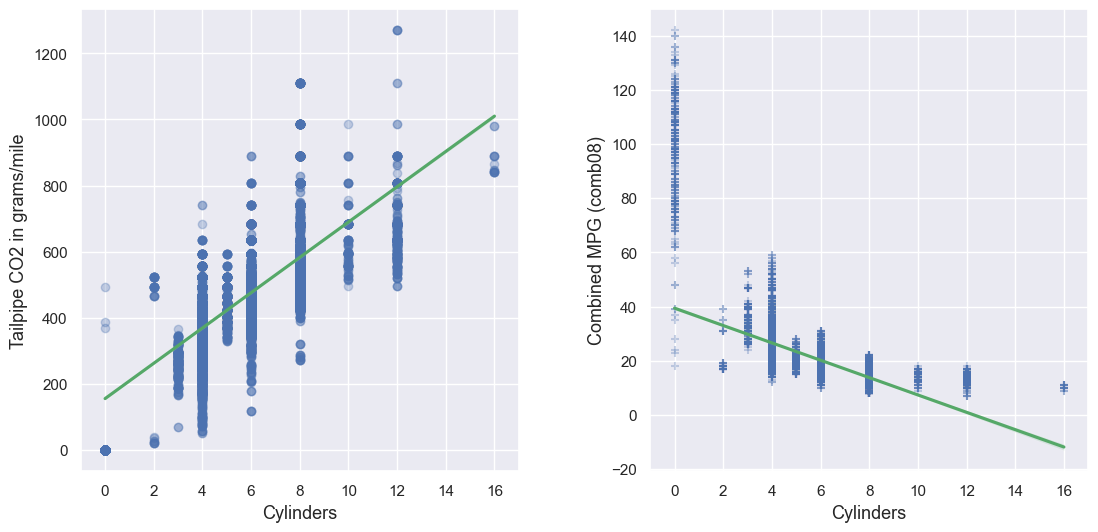

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
fig.subplots_adjust(hspace=0, wspace=0.3)
sns.regplot(x=X_train.cylinders, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile', fontsize=13)
axs[0].set_xlabel('Cylinders', fontsize=13)
axs[0].set_xlim([-1,17])
sns.regplot(x=X_train.cylinders, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Cylinders', fontsize=13)
axs[1].set_xlim([-1,17])
plt.show() 

In [70]:
shap.dependence_plot("co2TailpipeGpm", shap_nn_values_test[0],\
                     X_test, alpha=0.3,\
                     interaction_index="co2", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tco2→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(X_train.co2.values, X_train.co2TailpipeGpm.values)))

NameError: name 'shap_nn_values_test' is not defined

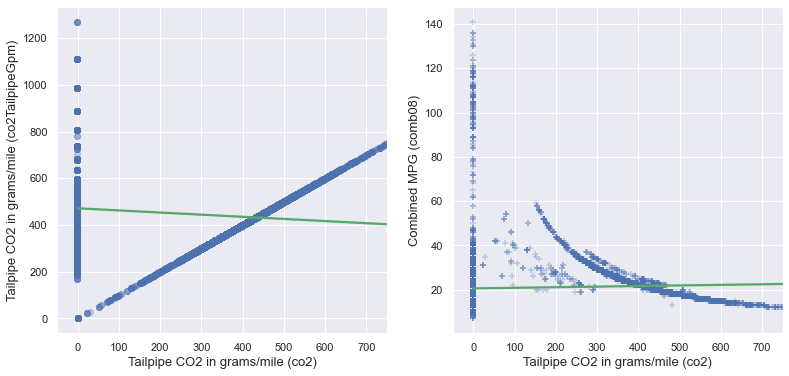

In [53]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
sns.regplot(x=X_train.co2, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile (co2TailpipeGpm)',\
                  fontsize=13)
axs[0].set_xlabel('Tailpipe CO2 in grams/mile (co2)', fontsize=13)
axs[0].set_xlim([-50, 750])
sns.regplot(x=X_train.co2, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('Tailpipe CO2 in grams/mile (co2)', fontsize=13)
axs[1].set_xlim([-50, 750])
plt.show() 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


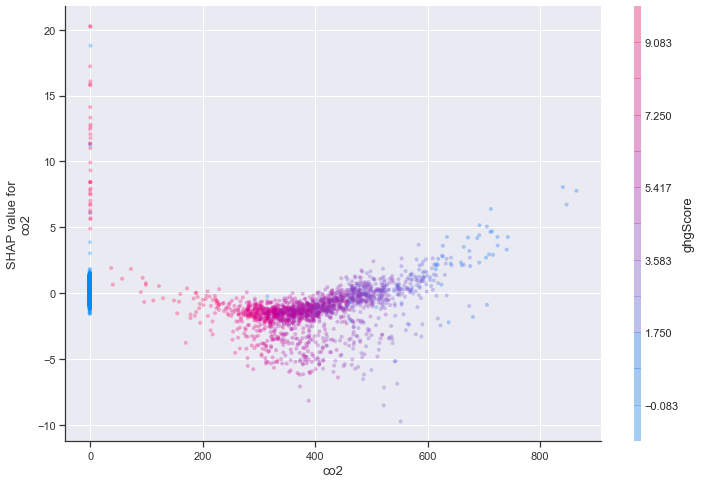

spearman	ghgScore→co2	corr: 0.941	p-val: 0.0000


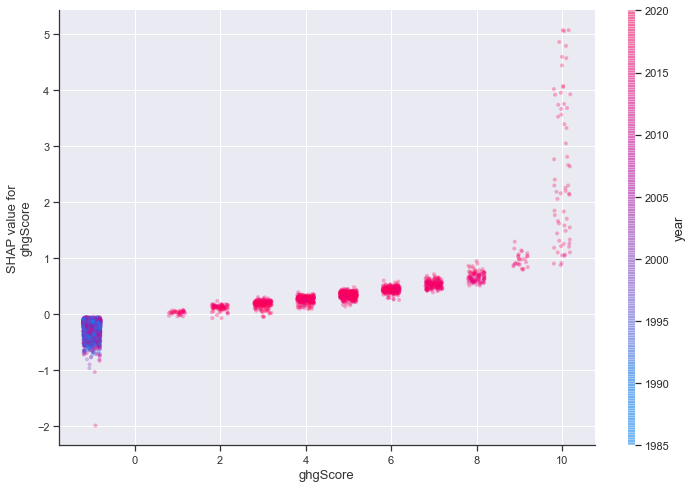

spearman	ghgScore→year	corr: 0.745	p-val: 0.0000


In [54]:
shap.dependence_plot("co2", shap_nn_values_test[0],\
                     X_test, alpha=0.3, x_jitter=10,\
                     interaction_index="ghgScore", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→co2\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.co2.values)))
shap.dependence_plot("ghgScore", shap_nn_values_test[0],\
                     X_test, alpha=0.3, x_jitter=0.4,\
                     interaction_index="year", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()
print('spearman\tghgScore→year\tcorr: %.3f\tp-val: %.4f' % 
      (stats.spearmanr(top_df.ghgScore.values, top_df.year.values)))

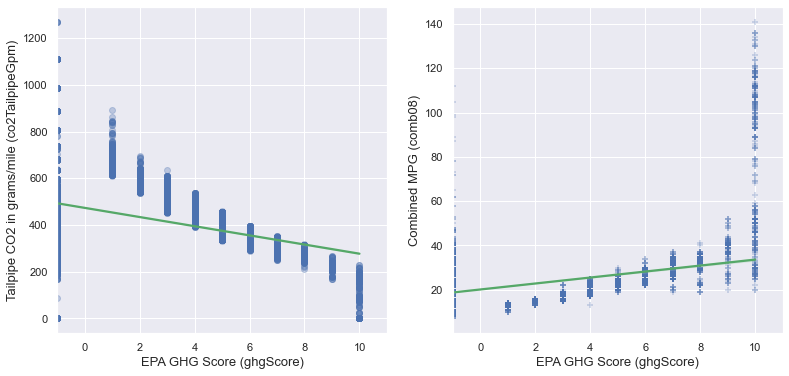

In [55]:
fig, axs = plt.subplots(1, 2, figsize = (13,6))
sns.regplot(x=X_train.ghgScore, y=X_train.co2TailpipeGpm, ax=axs[0],\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[0].set_ylabel('Tailpipe CO2 in grams/mile (co2TailpipeGpm)',\
                  fontsize=13)
axs[0].set_xlabel('EPA GHG Score (ghgScore)', fontsize=13)
axs[0].set_xlim([-1, 11])
sns.regplot(x=X_train.ghgScore, y=y_train, ax=axs[1], marker="+",\
            scatter_kws={'alpha':0.3}, line_kws={'color':'g'})
axs[1].set_ylabel('Combined MPG (comb08)', fontsize=13)
axs[1].set_xlabel('EPA GHG Score (ghgScore)', fontsize=13)
axs[1].set_xlim([-1, 11])
plt.show() 

### SHAP Force Plots

In [56]:
sample_test_size = 0.05
sample_test_idx = np.random.choice(X_test.shape[0],
                                   math.ceil(X_test.shape[0]*sample_test_size),\
                                   replace=False)
shap.initjs()
shap.force_plot(shap_xgb_explainer.expected_value,\
                shap_xgb_values_test[sample_test_idx],\
                X_test.iloc[sample_test_idx])

## Accumulated Local Effects (ALE) Plots

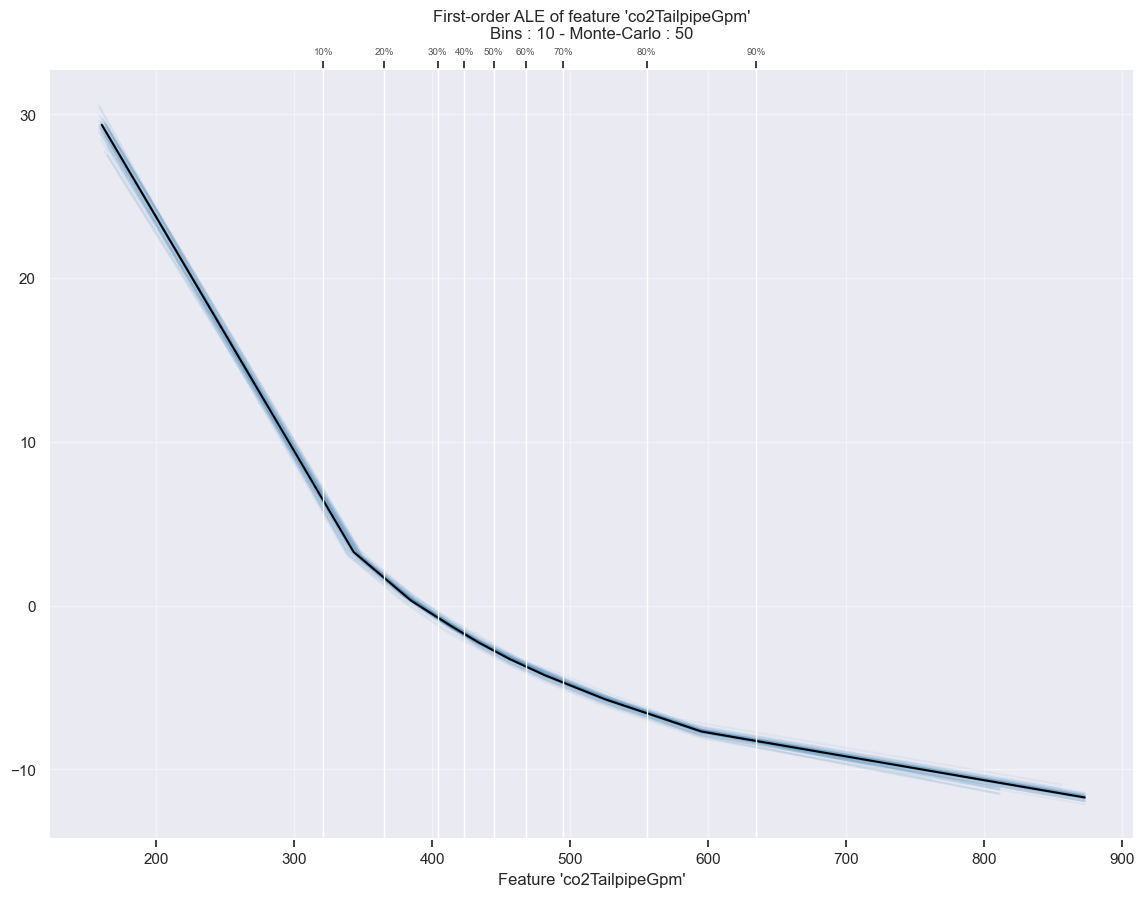

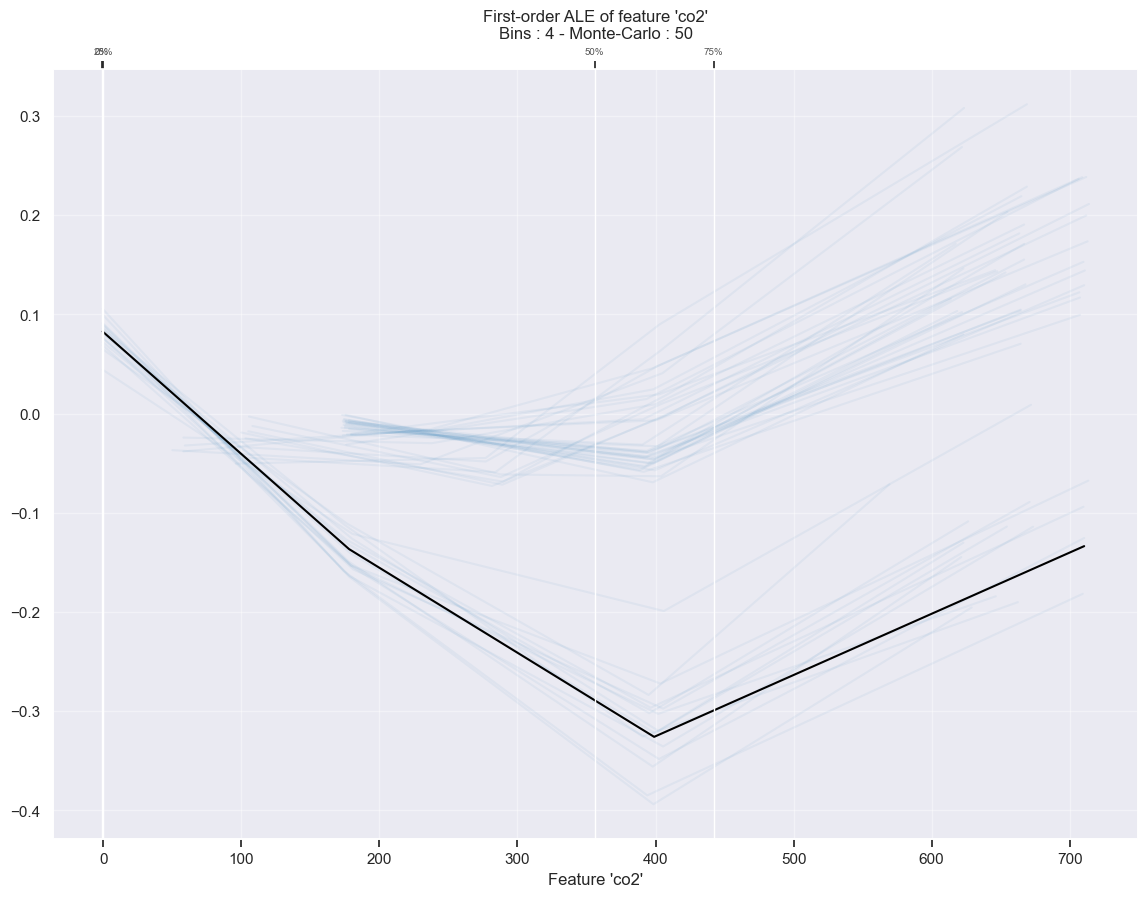

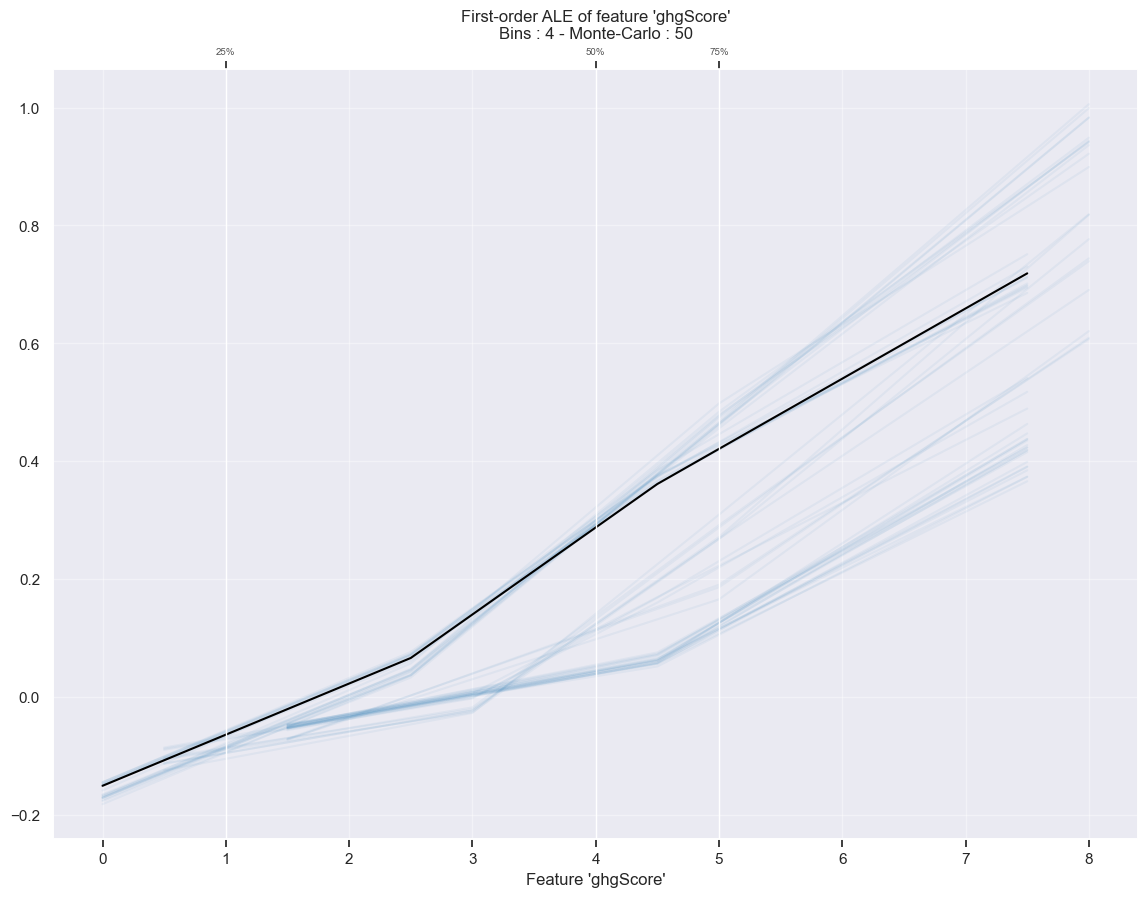

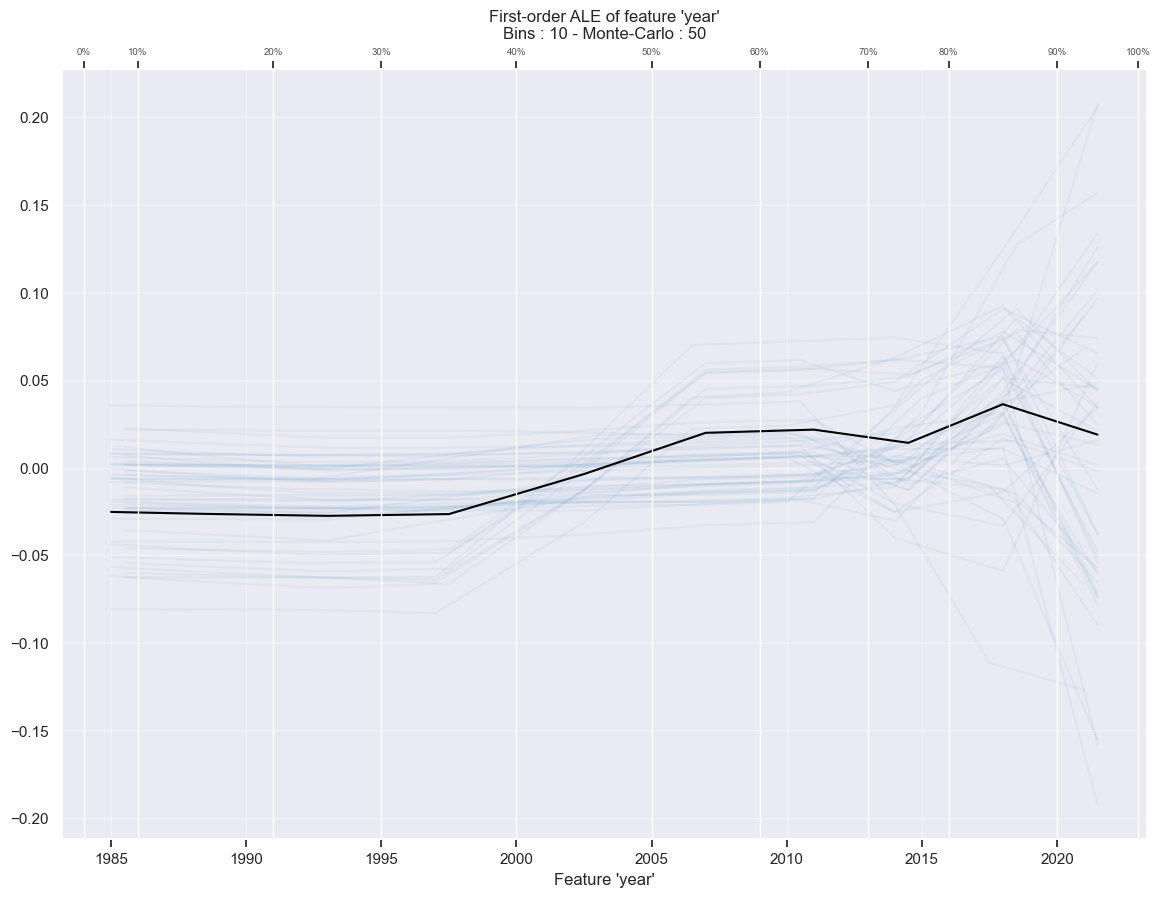

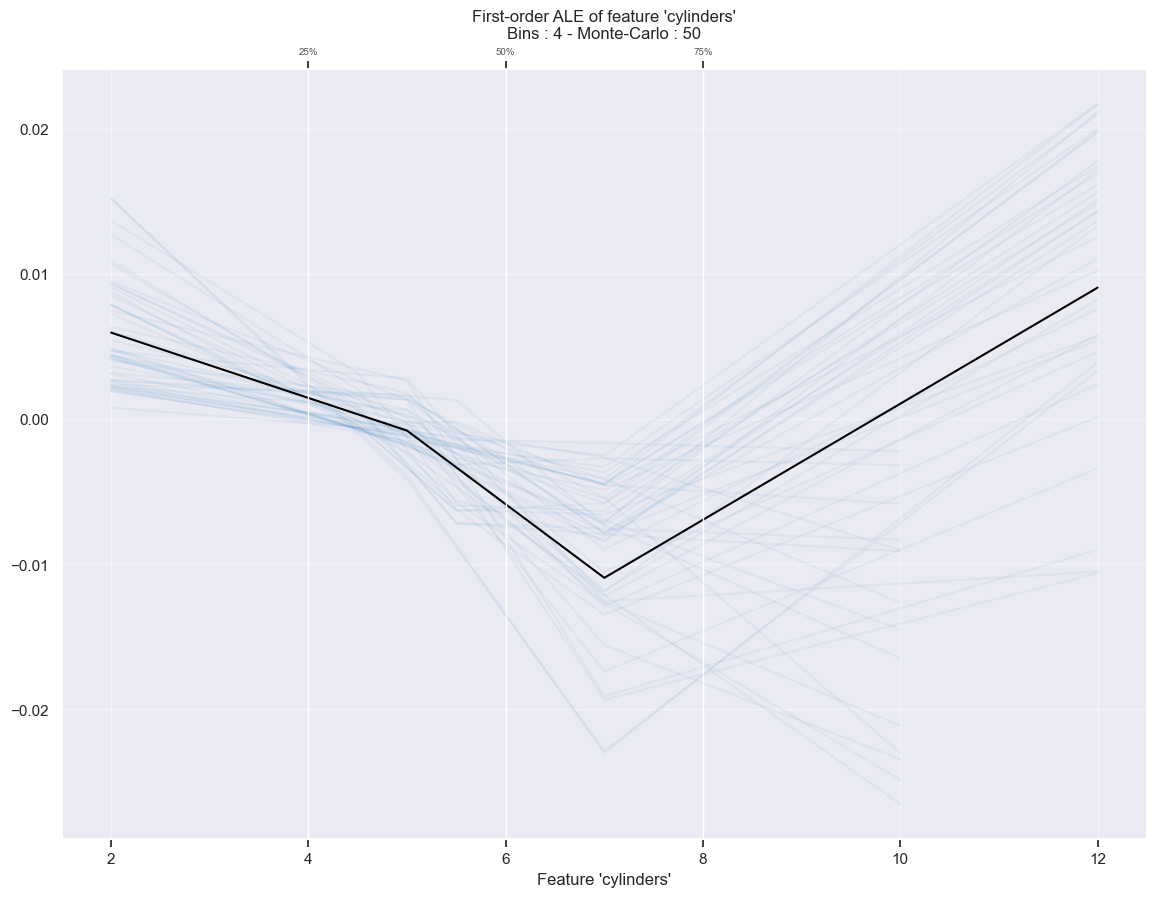

In [71]:
for feature_name in ['co2TailpipeGpm', 'co2', 'ghgScore',\
                     'year', 'cylinders']:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, [feature_name], bins=10,\
        monte_carlo=True, monte_carlo_rep=50,\
        monte_carlo_ratio=0.4
    )
    plt.show()

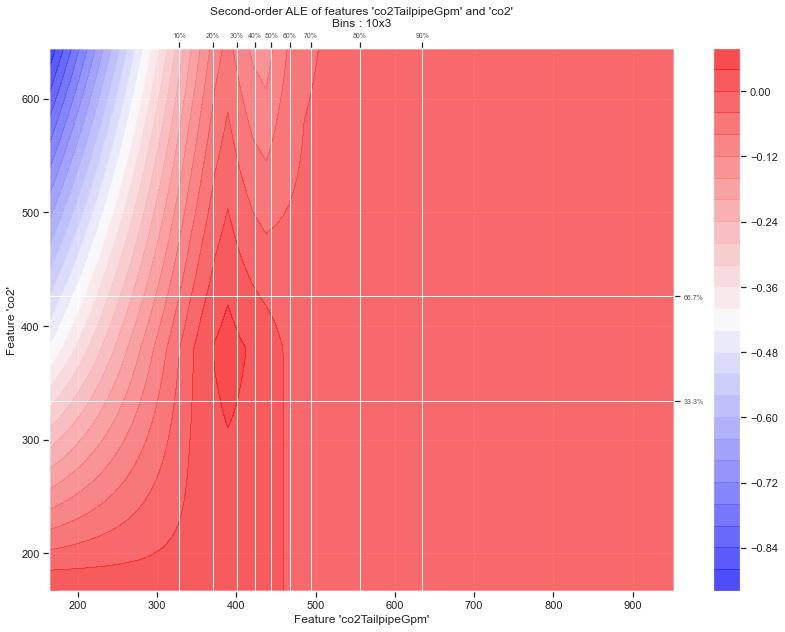

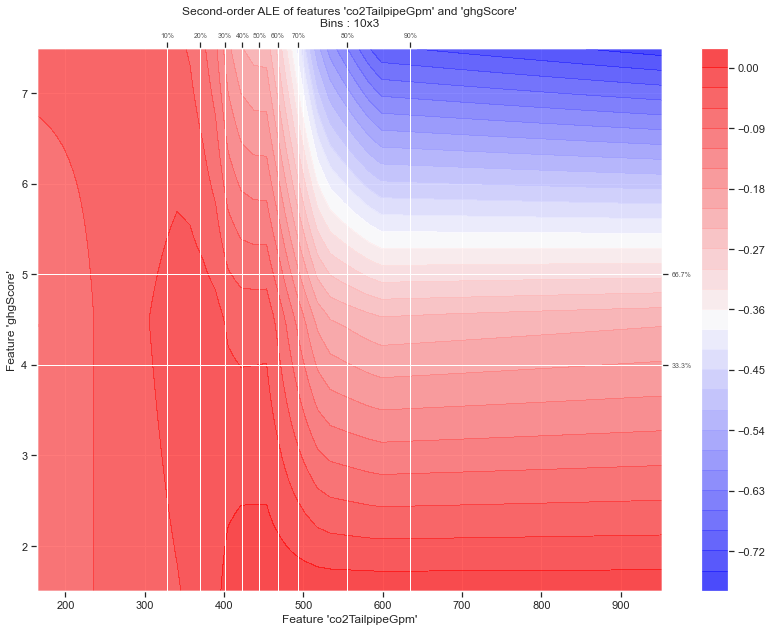

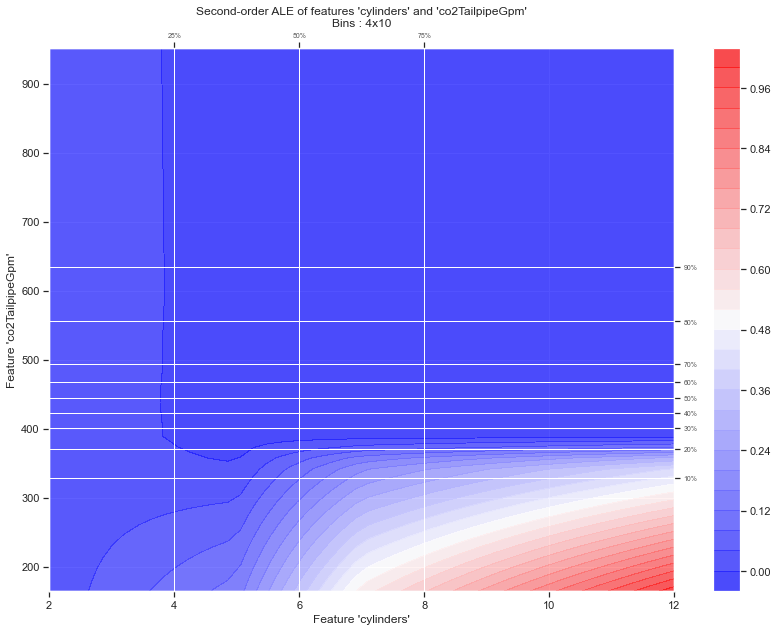

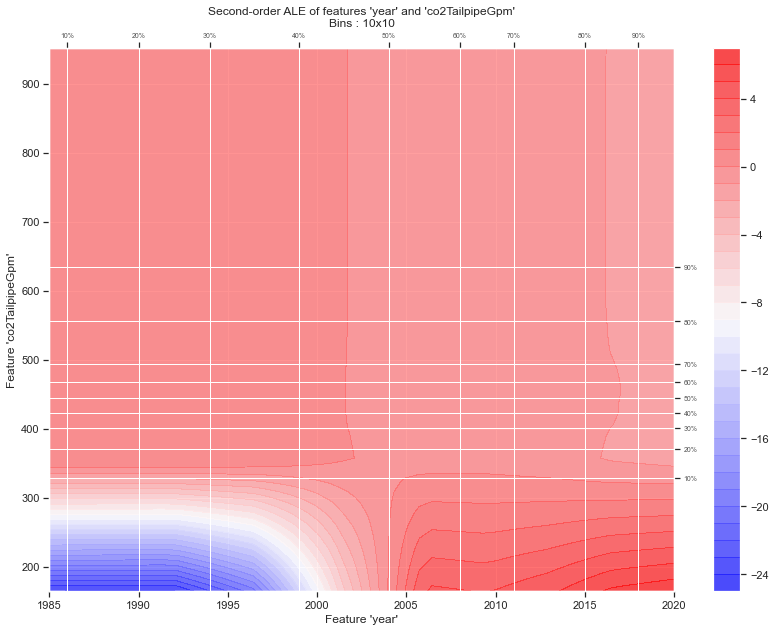

In [58]:
for interaction in [['co2TailpipeGpm', 'co2'], ['co2TailpipeGpm', 'ghgScore'],\
                    ['cylinders', 'co2TailpipeGpm'], ['year', 'co2TailpipeGpm']]:
    plt.rc("figure", figsize=(14, 10))
    ale_plot(
        fitted_xgb_model, X_test, interaction, bins=[10,10]
    )
    plt.show()

## Global Surrogates

### Fitting Surrogates

In [59]:
fitted_dt_surrogate = tree.DecisionTreeRegressor(max_depth=7,\
                                                 random_state=rand).\
                                        fit(X_train, y_train_nn_pred)
y_train_dt_pred = fitted_dt_surrogate.predict(X_train)
y_test_dt_pred = fitted_dt_surrogate.predict(X_test)

In [60]:
fitted_rf_surrogate = RuleFit(max_rules=150, rfmode='regress',\
                              random_state=rand, tree_size=8).\
                        fit(X_train.astype(float).values,\
                            np.array(y_train_nn_pred).squeeze(),\
                            X_train.columns)
y_train_rf_pred = fitted_rf_surrogate.predict(X_train.astype(float).values)
y_test_rf_pred = fitted_rf_surrogate.predict(X_test.astype(float).values)

### Evaluating Surrogates

In [61]:
#Measure how well Decision Tree replicates Neural Network's predictions
RMSE_dt_nn_train = metrics.mean_squared_error(y_train_nn_pred,\
                                              y_train_dt_pred,\
                                              squared=False)
RMSE_dt_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
                                             y_test_dt_pred,\
                                             squared=False)
R2_dt_nn_test = metrics.r2_score(y_test_nn_pred, y_test_dt_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                (RMSE_dt_nn_train, RMSE_dt_nn_test, R2_dt_nn_test))

RMSE_train: 0.4805	RMSE_test: 0.6100	r2: 0.9944


In [62]:
#Measure how well Rule Fit replicates Neural Network's predictions
RMSE_rf_nn_train = metrics.mean_squared_error(y_train_nn_pred,\
                                              y_train_rf_pred,\
                                              squared=False)
RMSE_rf_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
                                             y_test_rf_pred,\
                                             squared=False)
R2_rf_nn_test = metrics.r2_score(y_test_nn_pred, y_test_rf_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
                (RMSE_rf_nn_train, RMSE_rf_nn_test, R2_rf_nn_test))

RMSE_train: 0.9150	RMSE_test: 0.9049	r2: 0.9877


### Interpreting Surrogates

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


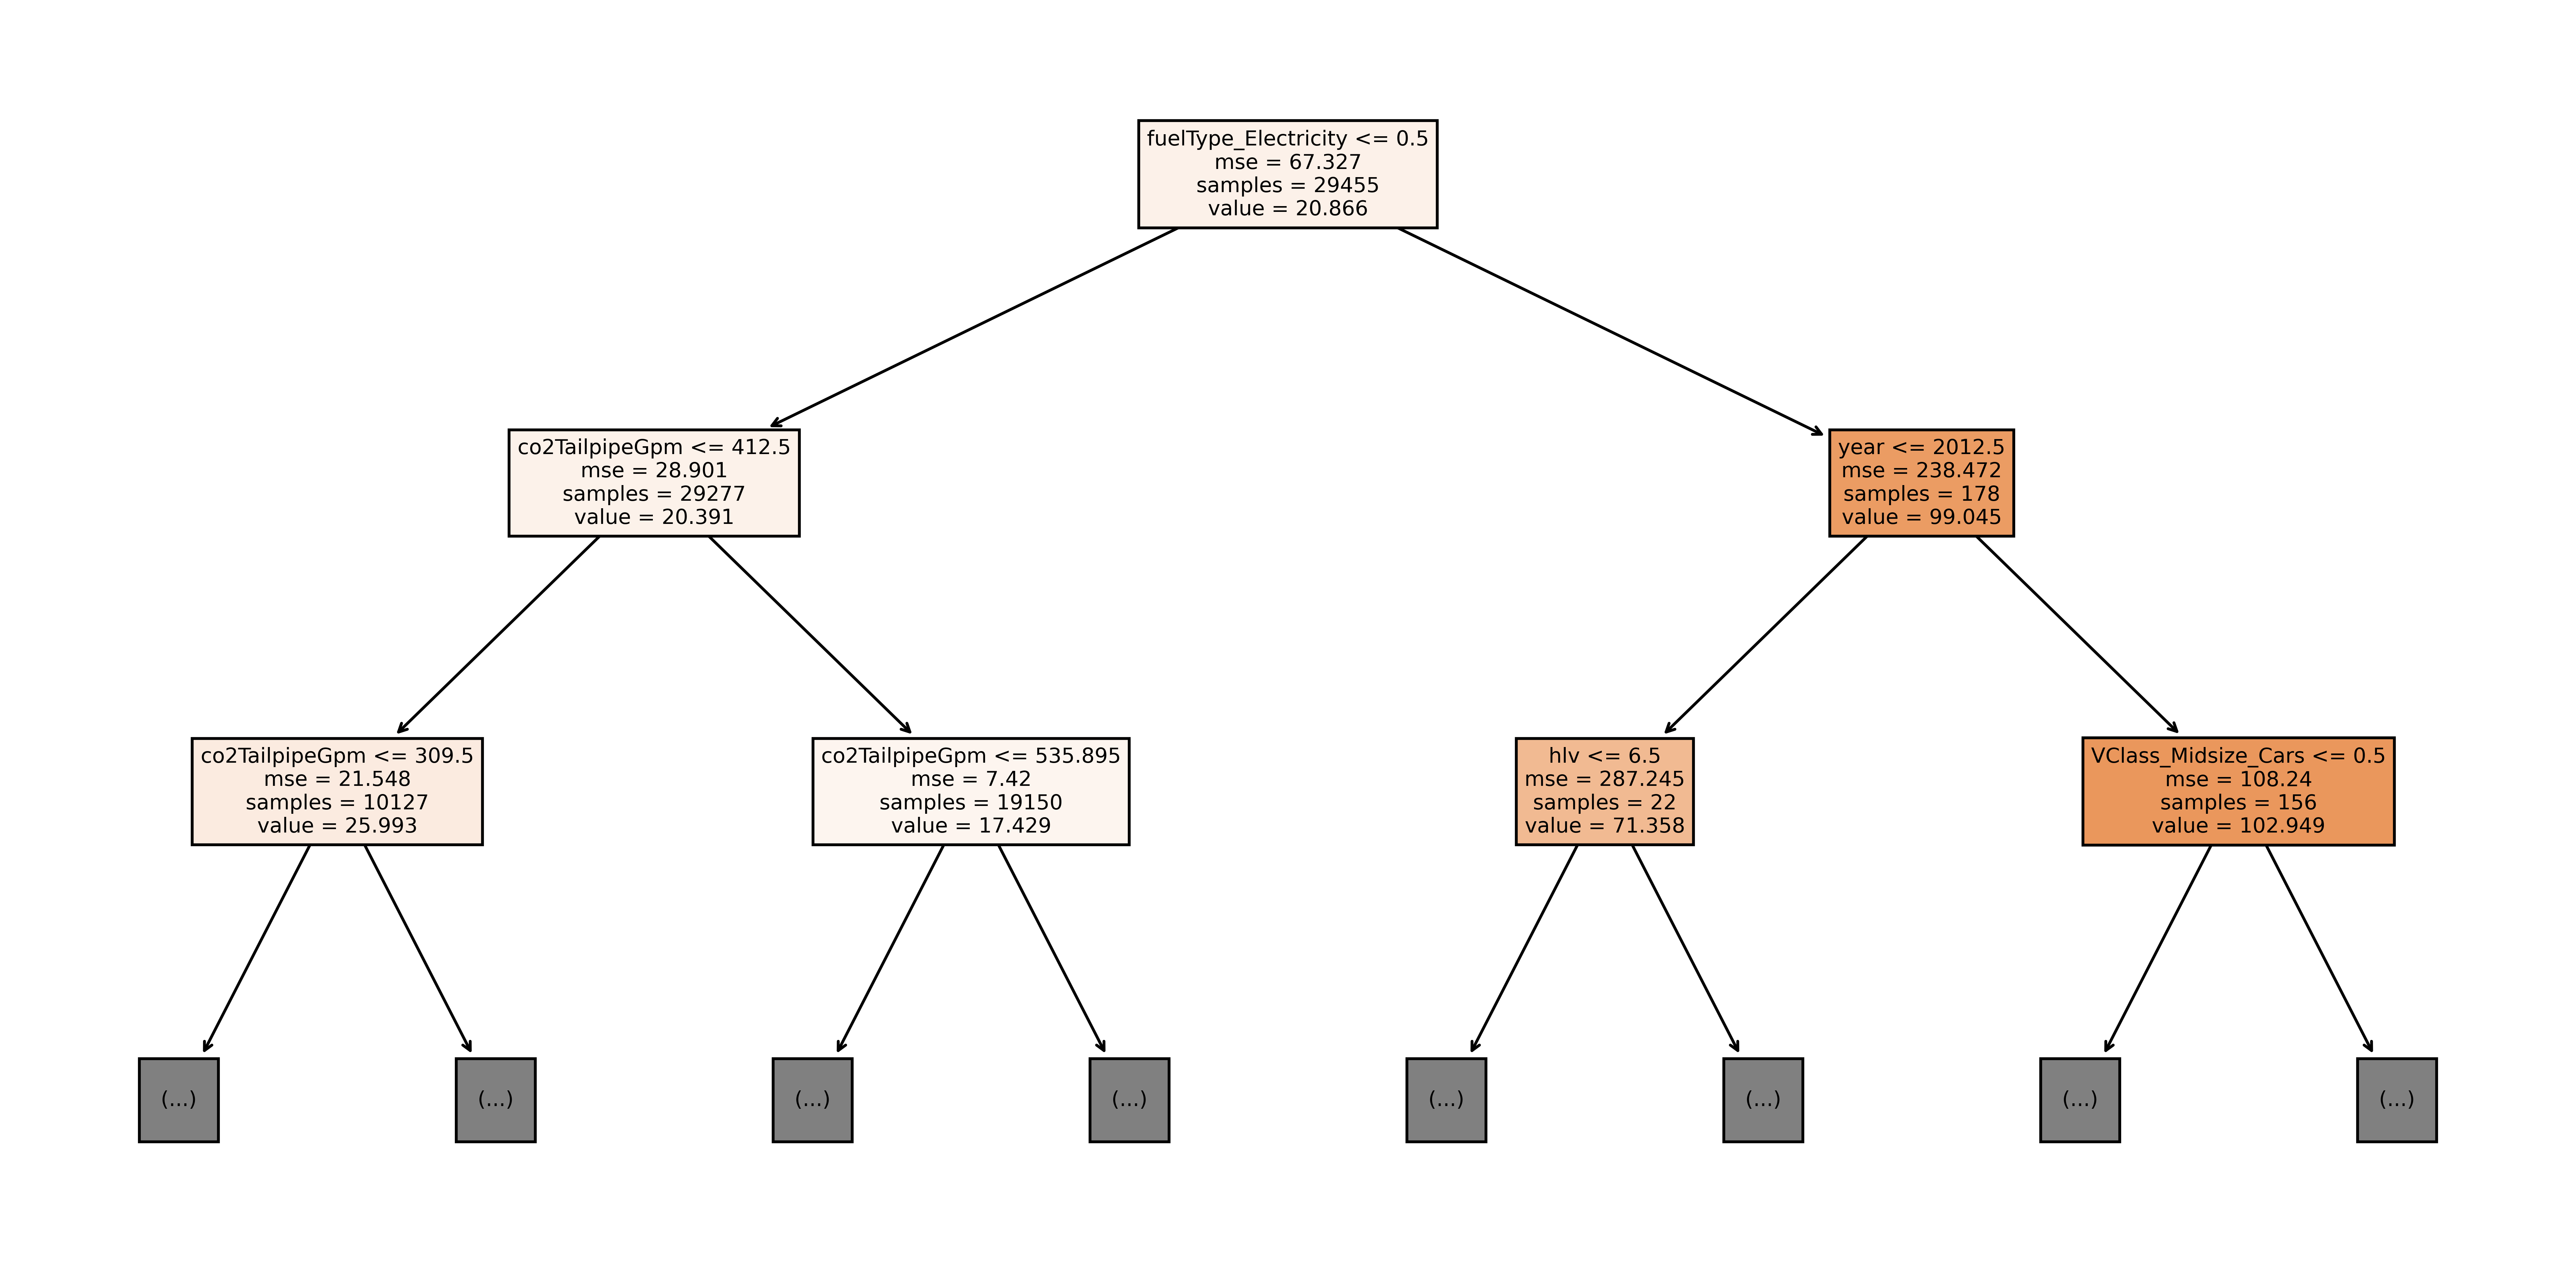

In [63]:
sns.reset_orig()
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [64]:
text_tree = tree.export_text(fitted_dt_surrogate,\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- fuelType_Electricity <= 0.50
|   |--- co2TailpipeGpm <= 412.50
|   |   |--- co2TailpipeGpm <= 309.50
|   |   |   |--- co2TailpipeGpm <= 234.43
|   |   |   |   |--- drive_Front-Wheel <= 0.50
|   |   |   |   |   |--- atvType_Other <= 0.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 197.88
|   |   |   |   |   |   |   |--- value: [49.54]
|   |   |   |   |   |   |--- co2TailpipeGpm >  197.88
|   |   |   |   |   |   |   |--- value: [40.34]
|   |   |   |   |   |--- atvType_Other >  0.50
|   |   |   |   |   |   |--- co2TailpipeGpm <= 165.50
|   |   |   |   |   |   |   |--- value: [32.85]
|   |   |   |   |   |   |--- co2TailpipeGpm >  165.50
|   |   |   |   |   |   |   |--- value: [29.28]
|   |   |   |   |--- drive_Front-Wheel >  0.50
|   |   |   |   |   |--- co2TailpipeGpm <= 194.50
|   |   |   |   |   |   |--- hlv <= 19.50
|   |   |   |   |   |   |   |--- value: [46.85]
|   |   |   |   |   |   |--- hlv >  19.50
|   |   |   |   |   |   |   |--- value: [53.64]
|   |   |   |   |   |--- c

In [65]:
rulefit_df = fitted_rf_surrogate.get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0]
rulefit_df.sort_values(by="importance", ascending=False)

rule    type       coef  \
4                                       co2TailpipeGpm  linear  -0.032542   
132                                   atvType_EV > 0.5    rule  24.897840   
88                         displ > 0.30000001192092896    rule -14.924096   
167                 cylinders <= 1.0 & ghgScore <= 4.5    rule -17.959679   
14                                     fuelType_Diesel  linear   3.624268   
..                                                 ...     ...        ...   
38                         VClass_Small_Station_Wagons  linear   0.034334   
64                                   eng_dscr_CA_model  linear   0.013023   
26                                    drive_Rear-Wheel  linear   0.009481   
177  co2TailpipeGpm <= 86.0 & co2TailpipeGpm <= 377...    rule   0.015664   
92   co2TailpipeGpm <= 535.8947448730469 & co2Tailp...    rule  -0.000027   

      support  importance  
4    1.000000    3.663626  
132  0.008857    2.332828  
88   0.992914    1.251820  
167  0.001771    0.755234  
14   1.000000    0.596587  
..        ...         ...  
38   1.000000    0.006595  
64   1.000000    0.006403  
26   1.000000    0.004467  
177  0.003543    0.000931  
92   0.325066    0.000013  

[89 rows x 5 columns]